[![](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ganegroup/workshop_nn/blob/main/08e_AlexNet.ipynb)

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow_datasets as tfds
import numpy as np
import seaborn as sns
sns.set_theme()

2023-07-02 15:43:14.827348: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.list_physical_devices()

2023-07-02 15:43:16.531599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 15:43:16.534761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 15:43:16.534881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.keras.regularizers import l2

In [4]:
def create_AlexNet(input_shape=[227, 227, 3], num_classes=2, activation="relu", pooling_layer=layers.MaxPooling2D, batch_normalization=True, kernel_regularizer=l2(5e-4)):
    """Create a keras sequencial model based on the AlexNet architecture"""

    first_kernel_size = 11
    pool_size = 3
    
    model = Sequential()
    
    model.add(layers.Conv2D(filters=96, kernel_size=first_kernel_size, strides=4, activation=activation, padding="valid", input_shape=input_shape))
    model.add(pooling_layer(pool_size=pool_size, strides=2, padding="valid"))
    if batch_normalization:
        model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=256, kernel_size=5, strides=1, activation=activation, padding="same", kernel_regularizer=kernel_regularizer))
    model.add(pooling_layer(pool_size=pool_size, strides=2, padding="valid"))
    if batch_normalization:
        model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=384, kernel_size=3, strides=1, activation=activation, padding="same", kernel_regularizer=kernel_regularizer))
    if batch_normalization:
        model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=384, kernel_size=3, strides=1, activation=activation, padding="same", kernel_regularizer=kernel_regularizer))
    if batch_normalization:
        model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=256, kernel_size=3, strides=1, activation=activation, padding="same", kernel_regularizer=kernel_regularizer))
    if batch_normalization:
        model.add(layers.BatchNormalization())

    model.add(pooling_layer(pool_size=pool_size, strides=2, padding="valid"))

    model.add(layers.Flatten())

    model.add(layers.Dense(units=4096, activation=activation))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(units=4096, activation=activation))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(units=num_classes, activation="softmax"))

    return model

In [5]:
num_classes = 2


model = create_AlexNet()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                        

2023-07-02 15:43:16.575935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 15:43:16.576138: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 15:43:16.576301: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
# Data loading and preprocessing

(train_data, validation_data), info = tfds.load('cats_vs_dogs', split=["train[:75%]", "train[75%:]"], with_info=True, as_supervised=True)

In [7]:
def normalize(image, label):
    """ Normalize image: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

def to_categorical(image, label):
    return image, tf.one_hot(tf.cast(label, tf.int32), num_classes)

def resize(image, label):
    """ Resize the image"""
    image = tf.image.resize(image, [227, 227], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image, label

# initiliaze the color normalization layer
normalization_layer = layers.Normalization(axis=None)
normalization_layer.adapt(train_data.map(normalize).map(lambda x, y: x))


def pipeline(dataset):
    dataset = dataset.map(normalize)
    dataset = dataset.map(lambda x, y: (normalization_layer(x), y))
    dataset = dataset.map(to_categorical)
    dataset = dataset.map(resize)
    dataset = dataset.cache()
    dataset = dataset.shuffle(info.splits['train[:75%]'].num_examples)
    return dataset

processed_train_data = pipeline(train_data)
processed_validation_data = pipeline(validation_data)

batch_size = 64

batched_train_data = processed_train_data.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
batched_validation_data = processed_validation_data.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

2023-07-02 15:43:17.268300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [6]
	 [[{{node Placeholder/_4}}]]
2023-07-02 15:43:17.268508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [6]
	 [[{{node Placeholder/_2}}]]
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 ex

In [8]:
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomZoom((-0.2, 0.2)),
  layers.RandomTranslation(
    (-0.1, 0.1), (-0.1, 0.1)
  ),
  layers.RandomRotation(0.2),
])

In [9]:
batched_train_data = batched_train_data.map(lambda x, y: (data_augmentation(x), y))

2023-07-02 15:43:30.283916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_41' with dtype resource
	 [[{{node Placeholder/_41}}]]
2023-07-02 15:43:30.284374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_42' with dtype resource
	 [[{{node Placeholder/_42}}]]
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes befo

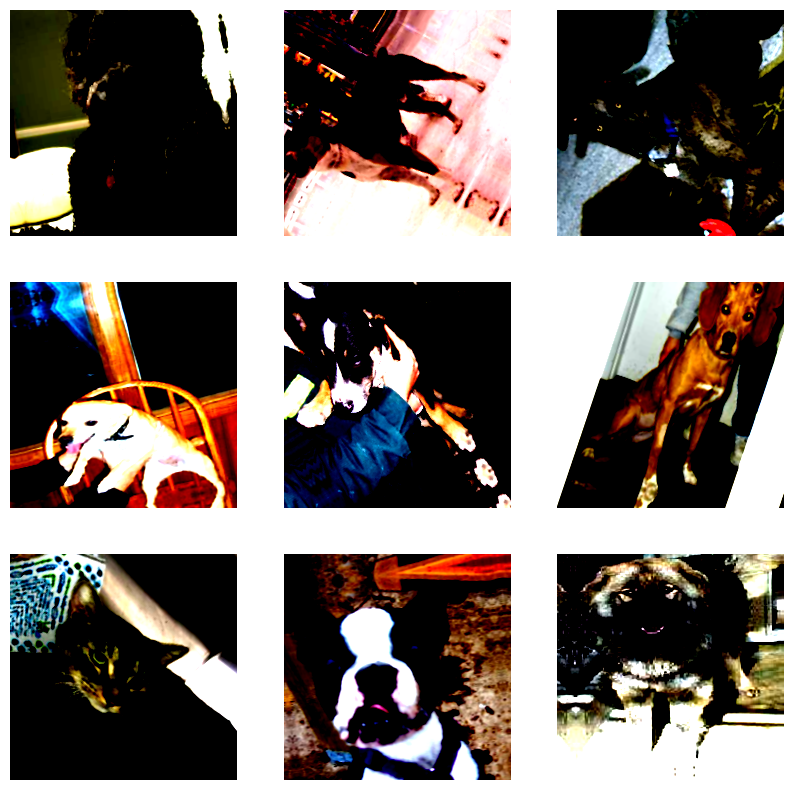

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, _ in batched_train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis("off")

In [11]:
lr_reducer = ReduceLROnPlateau(monitor="val_loss", factor=np.sqrt(0.1))
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [12]:
history = model.fit(
    batched_train_data,
    epochs=50,
    validation_data=batched_validation_data,
    callbacks=[lr_reducer]
)

Epoch 1/50


2023-07-02 15:43:38.666622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_22' with dtype float and shape [1,1,1]
	 [[{{node Placeholder/_22}}]]
2023-07-02 15:43:38.667170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_21' with dtype float and shape [1,1,1]
	 [[{{node Placeholder/_21}}]]
2023-07-02 15:43:40.345752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-02 15:43:40.982046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07

273/273 [==============================] - ETA: 0s - loss: 1.6295 - accuracy: 0.5590

2023-07-02 15:45:27.505448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [2]
	 [[{{node Placeholder/_2}}]]
2023-07-02 15:45:27.505753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [2]
	 [[{{node Placeholder/_3}}]]
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


273/273 [==============================] - 113s 401ms/step - loss: 1.6295 - accuracy: 0.5590 - val_loss: 1.2101 - val_accuracy: 0.6365 - lr: 0.0010
Epoch 2/50
273/273 [==============================] - 107s 390ms/step - loss: 1.2703 - accuracy: 0.6090 - val_loss: 1.1673 - val_accuracy: 0.6671 - lr: 0.0010
Epoch 3/50
273/273 [==============================] - 107s 390ms/step - loss: 1.2265 - accuracy: 0.6347 - val_loss: 1.1465 - val_accuracy: 0.6860 - lr: 0.0010
Epoch 4/50
273/273 [==============================] - 107s 390ms/step - loss: 1.1876 - accuracy: 0.6632 - val_loss: 1.1106 - val_accuracy: 0.7196 - lr: 0.0010
Epoch 5/50
273/273 [==============================] - 107s 390ms/step - loss: 1.1504 - accuracy: 0.6907 - val_loss: 1.1126 - val_accuracy: 0.7050 - lr: 0.0010
Epoch 6/50
273/273 [==============================] - 106s 390ms/step - loss: 1.1320 - accuracy: 0.7001 - val_loss: 1.0886 - val_accuracy: 0.7268 - lr: 0.0010
Epoch 7/50
273/273 [==============================] - 106

<Axes: >

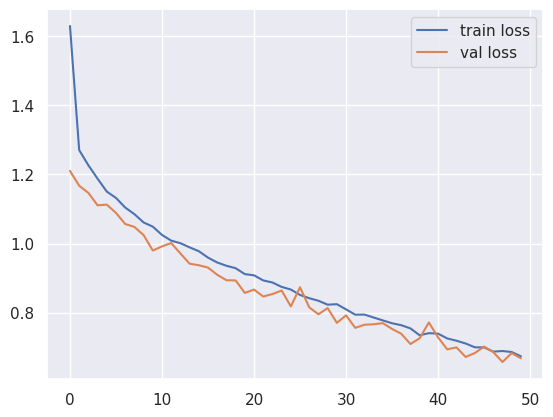

In [13]:
sns.lineplot(x=history.epoch, y=history.history['loss'], label="train loss")
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label="val loss")

<Axes: >

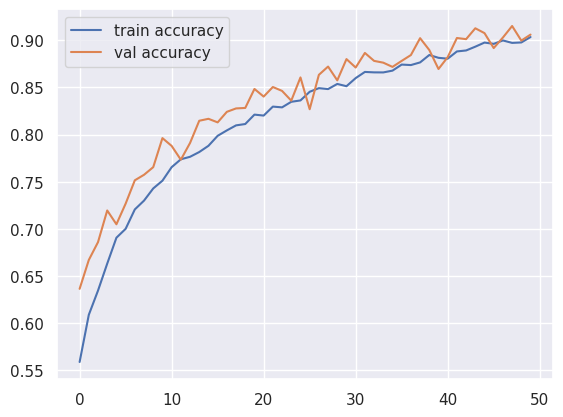

In [14]:
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label="train accuracy")
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label="val accuracy")